## Demonstration of Tasks

This notebook includes demonstration of listed tasks

Note: Please make sure the environment has been setup.
```bash
cd path/to/stock_forecasting
source set_env.sh
```

In [1]:
import time
import os
import pandas as pd
try:
    data_folder = os.environ['ASX_DATA_FOLDER']
except:
    data_folder = "./ASX-2015-2018"

## Data Processing

1. Converting the EOD data into ve seperate time series data frames; one
each for Open, High, Low Close and Volume. In each data frame, rows
should be indexed by date, and columns by ticker.

In [2]:
# Find a list of dates and the the full set of tickers
columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
dates = list()
tickers = set()
for fname in os.listdir(data_folder):
    file = os.path.join(data_folder, fname)
    df = pd.read_csv(file, header=None, names=columns, parse_dates=['date'])
    date = df.date[0]
    dates.append(date)
    tickers.update(df['ticker'].values)
print("Number of dates: ", len(dates))
print("Number of tickers: ", len(tickers))

Number of dates:  883
Number of tickers:  2773


In [3]:
# Read dateset to five data frames.
columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']
dates.sort()
df_open = pd.DataFrame(index=dates, columns=tickers)
df_high = pd.DataFrame(index=dates, columns=tickers)
df_low = pd.DataFrame(index=dates, columns=tickers)
df_close = pd.DataFrame(index=dates, columns=tickers)
df_volume = pd.DataFrame(index=dates, columns=tickers)
for fname in os.listdir(data_folder):
    file = os.path.join(data_folder, fname)
    df = pd.read_csv(file, header=None, names=columns, parse_dates=['date'],
                     dtype={'ticker': str, 'open': float, 'high': float, 'low': float, 'close': float, 'volume': int})
    date = df.date[0]
    df = df.set_index('ticker')
    df = df.transpose()
    df_open.loc[date, df.columns] = df.loc['open']
    df_high.loc[date, df.columns] = df.loc['high']
    df_low.loc[date, df.columns] = df.loc['low']
    df_close.loc[date, df.columns] = df.loc['close']
    df_volume.loc[date, df.columns] = df.loc['volume']

print("Five Data Frames are created:", df_open.shape, df_high.shape, df_low.shape, df_close.shape, df_volume.shape)

Five Data Frames are created: (883, 2773) (883, 2773) (883, 2773) (883, 2773) (883, 2773)


2. Create a data frame containing the future close returns as dened by Eq.
(1), in the same format. Also create a data frame containing close returns.

In [4]:
df_fcr = df_close.shift(-1) / df_close - 1
df_cr = df_close / df_close.shift(-1) - 1

3. Create a data frame containing the ratios of High/Low for each ticker each day, in the same format.

In [5]:
df_hl_ratio = df_high - df_low

## Exploratory Data Analysis

Next, carry out some appropriate EDA on the above time series, with the aim
of understanding key characteristics of the data, and discovering any statistical
associations.

1. Missing values.
   * They are clearly missing values represented as NaN in the data frames. Some tickers, e.g. INF and FEL, first appear after 2015-01-02. Some thicker, for example GFL and BUX, have missing values since their first appearance.
   * Some tickers do not have recent values. They will not be used for the forecasting. However, they can be used for test the forecasting models
   * Some tickers have very few values. They will not be used for forecasting models.

In [6]:
# Check the missing values since their first presentation.
def count_na(ticker):
    s = df_close[ticker]
    ind = s.first_valid_index()
    s = s[ind:]
    ind = s.isna()
    return s[ind]

# For example, find the dates with no value for a ticker
count_na('INF')

2018-04-19    NaN
2018-04-26    NaN
2018-05-08    NaN
2018-05-14    NaN
2018-05-15    NaN
2018-05-31    NaN
Name: INF, dtype: object

2. Time series structure. We see that the dates of data is not continuous. This is because ASX does not trade on weekend and public holidays. To analyze the data, I will ignore the close dates and use it as continuous.

([<matplotlib.axis.YTick at 0x13ddc7780>,
 <a list of 2 Text yticklabel objects>)

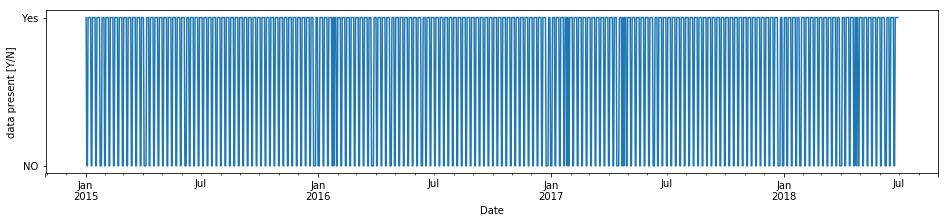

In [54]:
import numpy as np
from matplotlib import pyplot as plt
unit_series = pd.Series(index=dates, data=1)
full_dates = pd.date_range(dates[0], dates[-1], freq='1D')
full_series = pd.Series(index=full_dates, data=0)
series_dates = (full_series + unit_series).fillna(0)
series_dates
fig = plt.figure(figsize=(16, 3))
series_dates.plot()
plt.xlabel('Date')
plt.ylabel('data present [Y/N]')
plt.yticks([0, 1], ["NO", "Yes"])